In [74]:
import sys 
import os
import cymetric as cym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm
    
%matplotlib inline

In [85]:
add_intro = 12*5
trans_sfr = 12*15
### weak point....need to have these variables in a file that input + analysis both use ###

In [112]:
impt_times = [add_intro, trans_sfr]

In [186]:
#db = cym.dbopen('../output/test_py.sqlite')
db = cym.dbopen('../output/test_py_m120.sqlite')
ev = cym.Evaluator(db=db, write=False)

In [6]:
expinv = ev.eval('ExplicitInventoryByAgent')

In [64]:
# UOX Sep inventory
uox_sep = expinv.loc[expinv['AgentId'] == 297].loc[expinv['Time'] == 180]
uox_sep

,SimId,AgentId,Time,InventoryName,NucId,Quantity
299089,add61e95-986d-405b-8763-b21fe60c4ca7,297,180,feed-inv-name,551370000,2365.201170
299090,add61e95-986d-405b-8763-b21fe60c4ca7,297,180,feed-inv-name,922320000,0.000104
299091,add61e95-986d-405b-8763-b21fe60c4ca7,297,180,feed-inv-name,922330000,0.000431
299092,add61e95-986d-405b-8763-b21fe60c4ca7,297,180,feed-inv-name,922340000,36.182270
299093,add61e95-986d-405b-8763-b21fe60c4ca7,297,180,feed-inv-name,922350000,3452.157052
299094,add61e95-986d-405b-8763-b21fe60c4ca7,297,180,feed-inv-name,922360000,367.026596
299095,add61e95-986d-405b-8763-b21fe60c4ca7,297,180,feed-inv-name,922380000,100666.002054
299096,add61e95-986d-405b-8763-b21fe60c4ca7,297,180,feed-inv-name,942390000,591.300293
299097,add61e95-986d-405b-8763-b21fe60c4ca7,297,180,feed-inv-name,952410000,59.130029


In [69]:
# FF Sep inventory
ff_sep = expinv.loc[expinv['AgentId'] == 302].loc[expinv['Time'] == 284]
ff_sep

,SimId,AgentId,Time,InventoryName,NucId,Quantity
339306,add61e95-986d-405b-8763-b21fe60c4ca7,302,284,feed-inv-name,551370000,7.490000
339307,add61e95-986d-405b-8763-b21fe60c4ca7,302,284,feed-inv-name,922320000,0.000002
339308,add61e95-986d-405b-8763-b21fe60c4ca7,302,284,feed-inv-name,922330000,0.000075
339309,add61e95-986d-405b-8763-b21fe60c4ca7,302,284,feed-inv-name,922340000,0.749000
339310,add61e95-986d-405b-8763-b21fe60c4ca7,302,284,feed-inv-name,922350000,0.749000
339311,add61e95-986d-405b-8763-b21fe60c4ca7,302,284,feed-inv-name,922360000,0.749000
339312,add61e95-986d-405b-8763-b21fe60c4ca7,302,284,feed-inv-name,922380000,6349.272935
339313,add61e95-986d-405b-8763-b21fe60c4ca7,302,284,feed-inv-name,942390000,1123.499988
339314,add61e95-986d-405b-8763-b21fe60c4ca7,302,284,feed-inv-name,952410000,7.490000


In [57]:
# FFMixNon inventory
ff_mix = expinv.loc[expinv['AgentId'] == 298].loc[expinv['Time'] > 180].loc[expinv['Time'] < 183]
ff_mix

,SimId,AgentId,Time,InventoryName,NucId,Quantity
308272,add61e95-986d-405b-8763-b21fe60c4ca7,298,181,in_stream_0,942390000,4.536323e+02
308273,add61e95-986d-405b-8763-b21fe60c4ca7,298,181,in_stream_1,922380000,7.722869e+04
308274,add61e95-986d-405b-8763-b21fe60c4ca7,298,181,in_stream_2,922350000,2.500000e+05
308275,add61e95-986d-405b-8763-b21fe60c4ca7,298,181,in_stream_2,922380000,9.975000e+07
308276,add61e95-986d-405b-8763-b21fe60c4ca7,298,181,in_stream_3,922340000,1.907336e+06
308277,add61e95-986d-405b-8763-b21fe60c4ca7,298,182,in_stream_0,942390000,5.094560e+02
308278,add61e95-986d-405b-8763-b21fe60c4ca7,298,182,in_stream_1,922380000,1.507414e+05
308279,add61e95-986d-405b-8763-b21fe60c4ca7,298,182,in_stream_2,922350000,2.500000e+05
308280,add61e95-986d-405b-8763-b21fe60c4ca7,298,182,in_stream_2,922380000,9.975000e+07
308281,add61e95-986d-405b-8763-b21fe60c4ca7,298,182,in_stream_3,922340000,2.861002e+06


In [73]:
# Waste inventory @ following timestep
waste = expinv.loc[expinv['AgentId'] == 164].loc[expinv['Time'] == 181]
waste

,SimId,AgentId,Time,InventoryName,NucId,Quantity
57314,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,551370000,1832.857702
57315,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922320000,0.000081
57316,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922330000,0.000334
57317,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922340000,28.038609
57318,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922350000,2675.168912
57319,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922360000,284.418734
57320,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922380000,780.087798
57321,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,942390000,4.582144
57322,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,952410000,45.821443


In [52]:
col = np.divide(np.subtract(uox_sep['Quantity'].tolist(), waste['Quantity'].tolist()), uox_sep['Quantity'].tolist())
waste['Efficiency'] = col
waste

,SimId,AgentId,Time,InventoryName,NucId,Quantity,Efficiency
57314,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,551370000,1832.857702,0.225073
57315,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922320000,0.000081,0.225073
57316,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922330000,0.000334,0.225073
57317,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922340000,28.038609,0.225073
57318,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922350000,2675.168912,0.225073
57319,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922360000,284.418734,0.225073
57320,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,922380000,780.087798,0.992251
57321,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,942390000,4.582144,0.992251
57322,add61e95-986d-405b-8763-b21fe60c4ca7,164,181,inventory,952410000,45.821443,0.225073


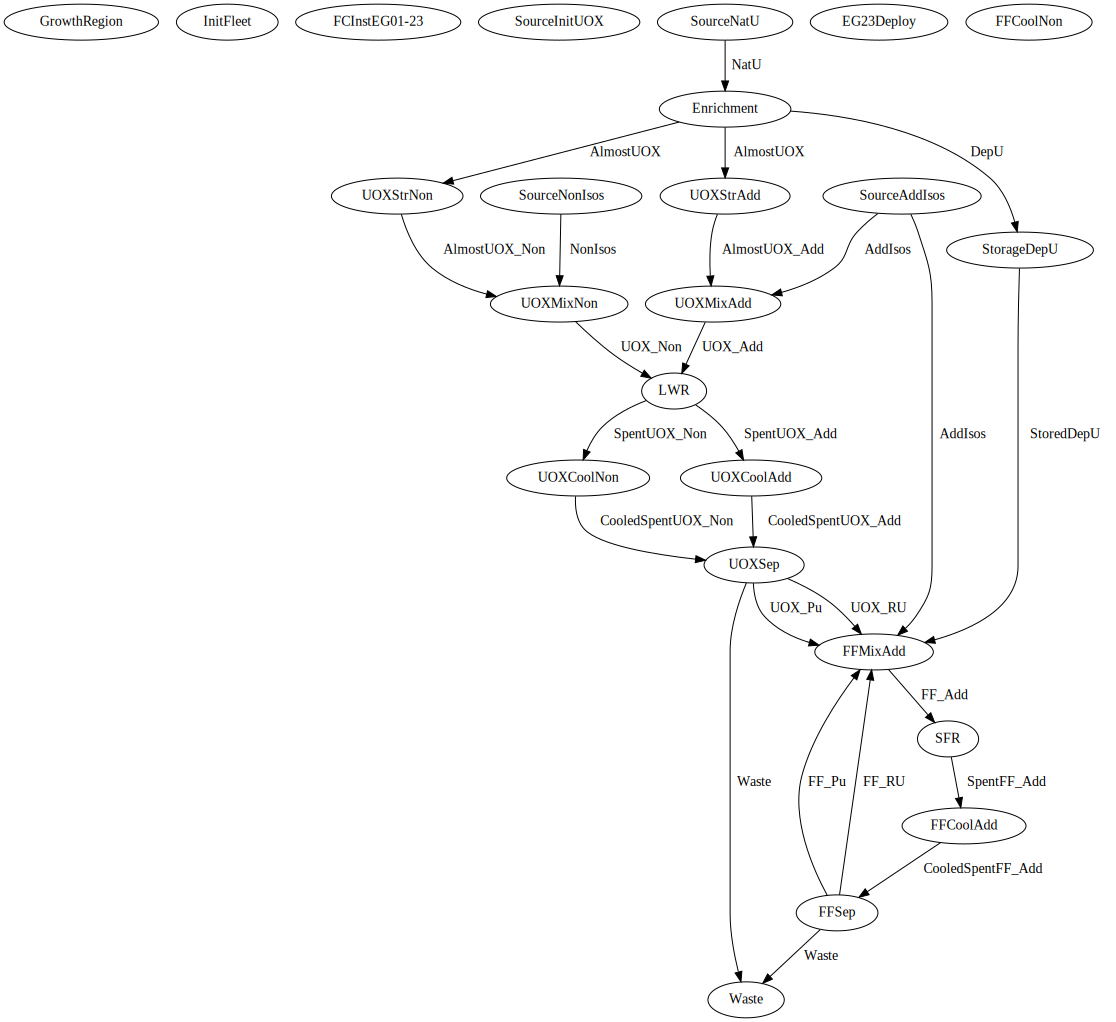

In [187]:
#[,'mass']
d = cgr.flow_graph(ev, label='com', start=18)
#d.render('eg23',format='png', view=True)
d

# Checking on Type of Fuel in Reactors

In [83]:
def rxtr_enter_exit_total(evaler):
        
    comm = evaler.eval('BuildSeries')
    decomm = evaler.eval('DecommissionSeries')

    neg = -decomm['Count']
    decomm = decomm.drop('Count',axis=1)
    decomm = pd.concat([decomm, neg],axis=1)
    
    comm = comm.rename(columns={'EnterTime':'Time'})
    decomm = decomm.rename(columns={'ExitTime':'Time'})
    
    comm = comm.pivot('Time','Prototype')['Count'].reset_index()
    decomm = decomm.pivot('Time','Prototype')['Count'].reset_index()
    comm_decomm = pd.merge(comm, decomm, left_on='Time', right_on='Time', how='outer', sort=True, \
                           suffixes=('_enter', '_exit')).fillna(0)
    comm_decomm.Time = comm_decomm.Time.astype(int)
    
    # get cumulative sums of _enter and_exit columns for reactors
    for rx in ['LWR', 'SFR']:
        comm_decomm[str(rx) + '_total'] = comm_decomm[str(rx) + '_enter'].cumsum() + \
                                          comm_decomm[str(rx) + '_exit'].cumsum()
    
    return comm_decomm[['Time', 'LWR_total', 'SFR_total']]

In [32]:
def fuel_quant(evaler):
    
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions = transactions.rename(columns={'TimeCreated':'Time'})
    uoxnon = transactions.loc[transactions['Commodity'] == 'UOX_Non'][['Time', 'Quantity']]
    uoxadd = transactions.loc[transactions['Commodity'] == 'UOX_Add'][['Time', 'Quantity']]
    ffnon = transactions.loc[transactions['Commodity'] == 'FF_Non'][['Time', 'Quantity']]
    ffadd = transactions.loc[transactions['Commodity'] == 'FF_Add'][['Time', 'Quantity']]
    
    fuel = evaler.eval('TimeList').rename(columns={'TimeStep':'Time'})
    
    fuel['UOXnon_refuel'] = uoxnon.groupby(['Time']).sum()['Quantity']
    fuel['UOXadd_refuel'] = uoxadd.groupby(['Time']).sum()['Quantity']
    fuel['FFnon_refuel'] = ffnon.groupby(['Time']).sum()['Quantity']
    fuel['FFadd_refuel'] = ffadd.groupby(['Time']).sum()['Quantity']
    fuel.fillna(0, inplace=True)
    fuel['total_refuel'] = fuel['UOXnon_refuel'] + fuel['UOXadd_refuel'] + fuel['FFnon_refuel'] + fuel['FFadd_refuel']
    fuel = fuel.loc[fuel['total_refuel'] > 0].reset_index(drop=True)    
    
    return fuel

In [33]:
def assem_swaps(evaler):
    
    events = evaler.eval('ReactorEvents')
    events = events.loc[(events['Event'] == 'LOAD') | (events['Event'] == 'DISCHARGE')].copy()
    vals = np.asarray(events['Value'].str.split().tolist())[:,0]
    events['Assemblies'] = [int(x) for x in vals]

    assem_swap = events[['Time', 'Event', 'Assemblies']].groupby(['Time', 'Event']).sum().reset_index()
    assem_swap = assem_swap.pivot('Time', 'Event')['Assemblies'].fillna(0).reset_index()
    
    return assem_swap

In [34]:
def fuel_pcts(evaler):
    assem_core = 3
    assem_size = 29565

    rxtrs = rxtr_enter_exit_total(evaler)
    fuels = fuel_quant(evaler)
    assem_swap = assem_swaps(evaler)

    f = fuels.merge(rxtrs, on='Time', how='outer', sort=True)
    f = f.merge(assem_swap, on='Time', how='outer', sort=True)
    f['LWR_total'] = f[['LWR_total']].fillna(method='ffill')
    f['SFR_total'] = f[['SFR_total']].fillna(method='ffill')
    f.drop(0, inplace=True)
    f.fillna(0, inplace=True)
    f.reset_index(drop=True, inplace=True)

    f['LWR_total_assem'] = assem_core * f['LWR_total']
    f['UOXnon_refuel_assem'] = f['UOXnon_refuel'] / assem_size
    f['UOXadd_refuel_assem'] = f['UOXadd_refuel'] / assem_size
    f['SFR_total_assem'] = assem_core * f['SFR_total']
    f['FFnon_refuel_assem'] = f['FFnon_refuel'] / assem_size
    f['FFadd_refuel_assem'] = f['FFadd_refuel'] / assem_size

# calculating percent of additive v nonadditive fuel
#!!!!!!!******
# presumes that upon introduction, only additive is replacing non-additive
# also (maybe obvious) presumes only non is replacing non in the beginning...
# this allows non_pct and add_pct to stay at 100 & 0, respectively, until additive is introduced
# have to assume discharge is always nonadditive until that runs out.....
#******!!!!!
# will need to update this for partial-additive assemblies 

    f['UOXnon_tally'] = 0
    f['UOXadd_tally'] = 0
    f['FFnon_tally'] = 0
    f['FFadd_tally'] = 0
    non_uox_track = 0
    add_uox_track = 0
    non_ff_track = 0
    add_ff_track = 0
    for i, row in f.iterrows():
        if row['Time'] < add_intro:
            f.loc[i, 'UOXnon_tally'] = row['LWR_total_assem'] #since the math is already done in this col
            non_uox_track = f.loc[i, 'UOXnon_tally']
        elif row['Time'] >= add_intro and row['Time'] < trans_sfr:
            if non_uox_track > 0:
                if non_uox_track - row['DISCHARGE'] < 0: # very last row of stepping down non_tally usually results in negatives
                    f.loc[i, 'UOXnon_tally'] = 0
                    f.loc[i, 'UOXadd_tally'] = add_uox_track + non_uox_track
                    non_uox_track = 0
                    add_uox_track = f.loc[i, 'UOXadd_tally']
                    
                else:
                    f.loc[i, 'UOXnon_tally'] = non_tally_track - row['DISCHARGE']
                    non_tally_track = f.loc[i, 'UOXnon_tally']
                    # this is the section where cumsum() would be used
                    f.loc[i, 'UOXadd_tally'] = add_tally_track + row['LOAD']
                    add_tally_track = f.loc[i, 'UOXadd_tally']
            else:
                f.loc[i, 'UOXadd_tally'] = row['LWR_total_assem'] #since the math is already done in this col
        
    f['UOXtot_check'] = f['UOXnon_tally'] + f['UOXadd_tally']
    f['UOXnon_pct'] = 100 * f['UOXnon_tally'] / f['LWR_total_assem']
    f['UOXadd_pct'] = 100 * f['UOXadd_tally'] / f['LWR_total_assem']

    # teeny test, should think about others
    check_pct = f['UOXnon_pct'] + f['UOXadd_pct'] - 100
    assert check_pct.sum() == 0.0

    return f

In [ ]:
f = fuel_pcts(ev)
filt = ['Time', 'DISCHARGE', 'LOAD', 'non_refuel_assem', 'add_refuel_assem', 'LWR_total_assem', 'non_tally', 'add_tally', 'tot_check', 'non_pct', 'add_pct']
f[filt].loc[f['Time'] > 56].head(15)

In [10]:
def plot_fuel_pcts(evaler):
    
    f = fuel_pcts(evaler)
    
    pcts = f[['Time', 'non_pct', 'add_pct']]

    ax = pcts.plot(x='Time', figsize=(11,7), legend=False)
    plt.xlabel('Time (months)',fontsize=20)
    plt.ylabel('Percent (%)',fontsize=20)
    plt.title('Percent Fuel without/with Additive', fontsize=20)
        
    legend = plt.legend(fontsize=14, title='Fuel Type', title_fontsize=14)
    legend.get_texts()[0].set_text('Without Additive')
    legend.get_texts()[1].set_text('With Additive')
        
    ax.minorticks_on()
    ax.tick_params(labelsize=16)
        
    plt.show()

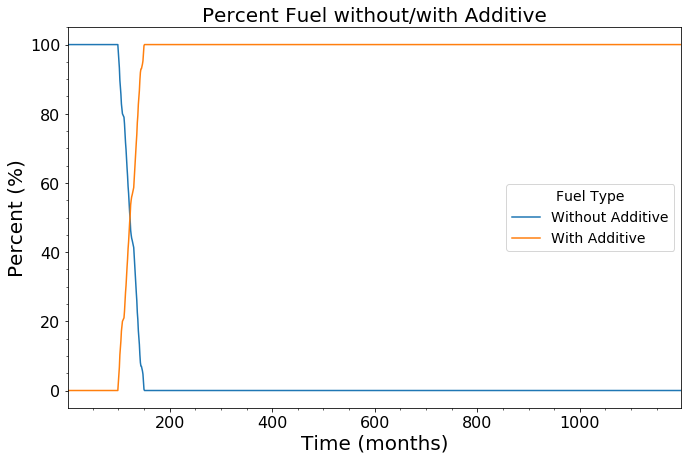

In [134]:
plot_fuel_pcts(ev)

# Mass Flows

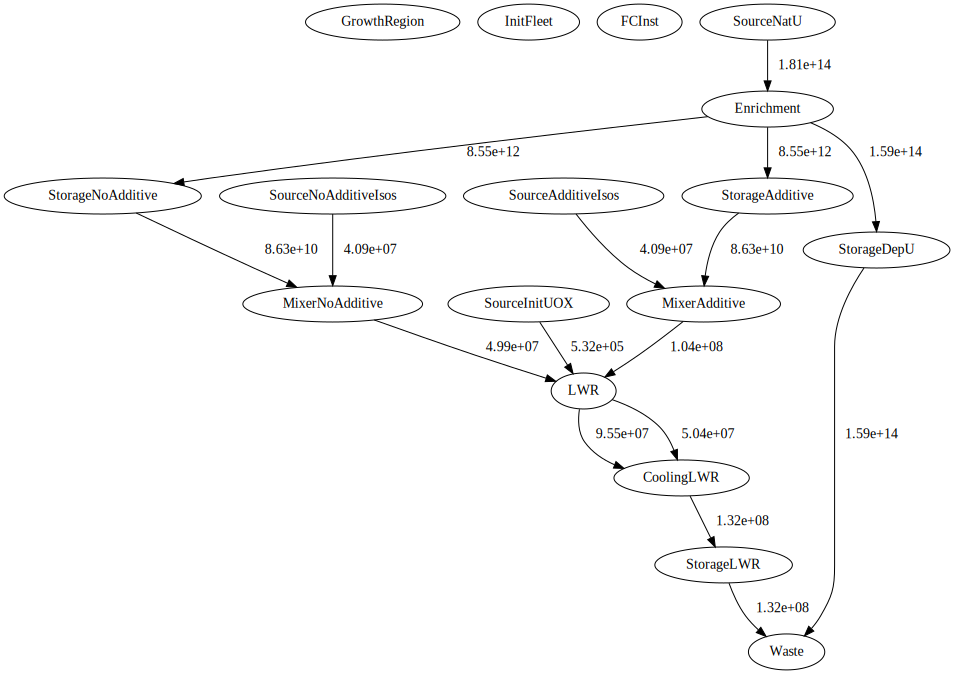

In [11]:
cgr.flow_graph(ev, label='mass')

In [131]:
def plot_flow(evaler, add_or_uox):
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions = transactions.rename(columns={'TimeCreated':'Time'})
    if add_or_uox == 'add':
        non = transactions.loc[transactions['Commodity'] == 'NonIsos']
        add = transactions.loc[transactions['Commodity'] == 'AddIsos']
        title = 'Mixer Additives'
    elif add_or_uox == 'uox':
        non = transactions.loc[transactions['Commodity'] == 'AlmostUOX_Non']
        add = transactions.loc[transactions['Commodity'] == 'AlmostUOX_Add']
        title = 'Mixer UOX'
    else:
        non = transactions.loc[transactions['Commodity'] == 'NatU']
        add = transactions.loc[transactions['Commodity'] == 'AlmostUOX']
        title = 'Enrichment Flow'
    
    flow = pd.DataFrame({'non_flow' : non.groupby(['Time']).sum()['Quantity'],
                         'add_flow' : add.groupby(['Time']).sum()['Quantity']}).reset_index()
    
    # Plotting mass flows at each time step
    ax = flow.plot(x='Time', figsize=(11,7), legend=False)
    plt.xlabel('Time (months)',fontsize=20)
    plt.ylabel('Mass of material flow (kg)',fontsize=20)
    plt.title(title, fontsize=20)
        
    legend = plt.legend(fontsize=14, title='UOX Flow Type', title_fontsize=14)
    legend.get_texts()[0].set_text('Without Additive')
    legend.get_texts()[1].set_text('With Additive')
        
    ax.minorticks_on()
    ax.tick_params(labelsize=16)
    #ax.set_ylim(0, 2.1e10)
        
    plt.show()


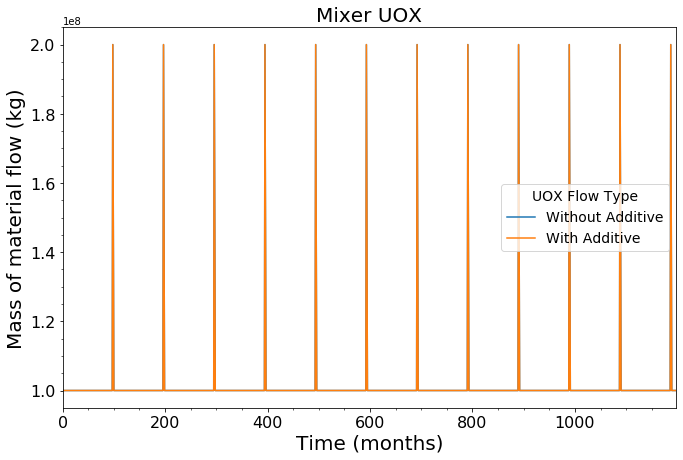

In [132]:
#AlmostUOX
plot_flow(ev, 'uox')

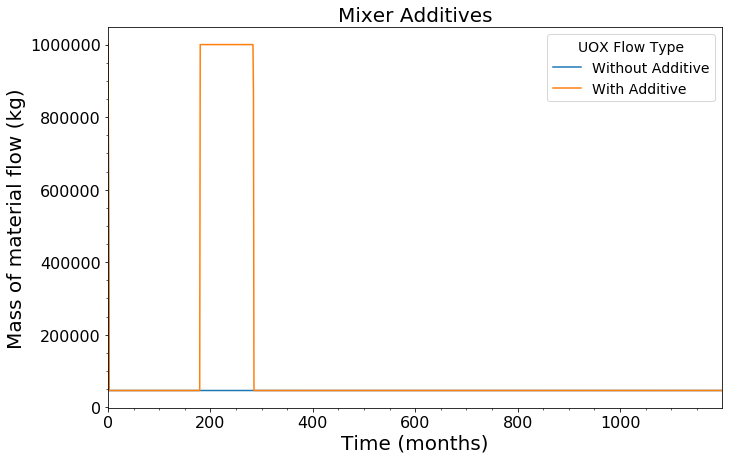

In [133]:
# Additive, NonAdditive
plot_flow(ev, 'add')

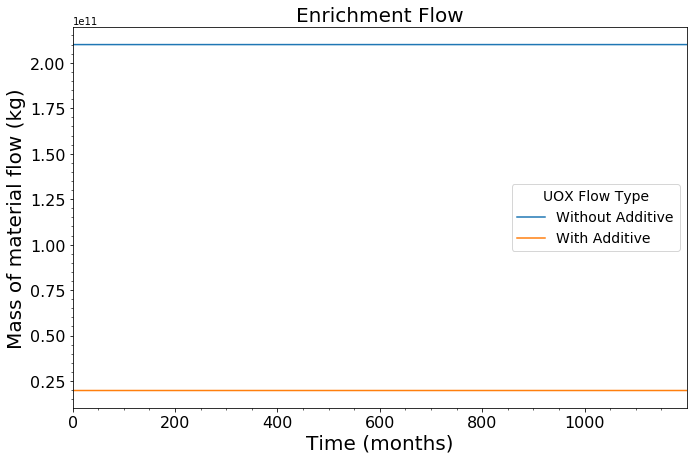

In [134]:
# NU is without A (2.1e11) and AlmostUOX is with A (2e10)
plot_flow(ev, 'enr')

In [159]:
def plot_rxtr_enter_exit_total(evaler):
        
    comm_decomm = rxtr_enter_exit_total(evaler)
    comm_decomm['Year'] = comm_decomm['Time'] / 12.
    ax = comm_decomm[['Year', 'LWR_total', 'SFR_total']].plot(x='Year', figsize=(9, 5), \
                                                              legend=False)
    
    legend = plt.legend(fontsize=14, title='Reactor Type', title_fontsize=14)
    legend.get_texts()[0].set_text('LWR')
    legend.get_texts()[1].set_text('SFR')
    legend.set_title('Prototype')
    plt.xlabel(r'Year', fontsize=18)
    plt.ylabel(r'Count',fontsize=18)
    ax.minorticks_on()
    ax.set_xticks(np.arange(0, 100, 10))
    ax.tick_params(labelsize=18)
    plt.axvline(x=trans_sfr/12., color='k', linestyle='--')
    plt.show()
    
    return 

In [190]:
def plot_fuel(evaler, flow_cumul):
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions['Year'] = transactions['TimeCreated'] / 12.
    non_uox = transactions.loc[transactions['Commodity'] == 'UOX_Non']
    add_uox = transactions.loc[transactions['Commodity'] == 'UOX_Add']
    non_ff = transactions.loc[transactions['Commodity'] == 'FF_Non']
    add_ff = transactions.loc[transactions['Commodity'] == 'FF_Add']
    
    if flow_cumul == 'cumul':
        transactions['UOXnon_total'] = non_uox['Quantity'].cumsum()
        transactions['UOXadd_total'] = add_uox['Quantity'].cumsum()
        transactions['FFnon_total'] = non_ff['Quantity'].cumsum()
        transactions['FFadd_total'] = add_ff['Quantity'].cumsum()
        transactions.fillna(method='ffill', inplace=True)
        transactions.fillna(0, inplace=True) # needed b/c ffill doesn't work on FFnon col
        transactions['total_fuel'] = (transactions['UOXnon_total'] + transactions['UOXadd_total'] + 
                                      transactions['FFnon_total'] + transactions['FFadd_total'])

        # Plotting cumulative fuel sent to reactors at each time step
        l = ['Year', 'UOXnon_total', 'UOXadd_total', 'FFnon_total', 'FFadd_total', 'total_fuel']
        ax = transactions[l].plot(x='Year', figsize=(11,7), legend=False)
        plt.xlabel('Year',fontsize=20)
        plt.ylabel('Mass of fuel fabricated (kg)',fontsize=20)

        legend = plt.legend(fontsize=14, title='Fuel Type', title_fontsize=14)
        legend.get_texts()[0].set_text('UOX without Additive')
        legend.get_texts()[1].set_text('UOX with Additive')
        legend.get_texts()[2].set_text('FF without Additive')
        legend.get_texts()[3].set_text('FF with Additive')
        legend.get_texts()[4].set_text('Total')
        
        lines = ax.get_children()
        lines[4].set_zorder(0)
    
        ax.minorticks_on()
        ax.set_xticks(np.arange(0, 100, 10))
        ax.tick_params(labelsize=18)
        
        for t in impt_times:
            plt.axvline(x=t/12., color='k', linestyle='--')

        ax.set_xlim(0, 40)
        ax.set_ylim(-4.9e6, 1e8)
        plt.show()
    elif flow_cumul == 'flow':
        flow = pd.DataFrame({'UOXnon_flow' : non_uox.groupby(['Year']).sum()['Quantity'],
                             'UOXadd_flow' : add_uox.groupby(['Year']).sum()['Quantity'],
                             'FFnon_flow'  : non_ff.groupby(['Year']).sum()['Quantity'],
                             'FFadd_flow'  : add_ff.groupby(['Year']).sum()['Quantity']
                            }).reset_index()
        
        # Plotting fuel flow to reactors at each time step
        ax = flow.plot(x='Year', figsize=(11,7), legend=False)
        plt.xlabel('Year',fontsize=20)
        plt.ylabel('Mass of fuel flow to reactors (kg)',fontsize=20)
        
        legend = plt.legend(fontsize=14, title='Fuel Type', title_fontsize=14)
        legend.get_texts()[0].set_text('UOX without Additive')
        legend.get_texts()[1].set_text('UOX with Additive')
        legend.get_texts()[2].set_text('FF without Additive')
        legend.get_texts()[3].set_text('FF with Additive')
        
        ax.minorticks_on()
        ax.set_xticks(np.arange(0, 100, 10))
        ax.tick_params(labelsize=18)
        
        for t in impt_times:
            plt.axvline(x=t/12., color='k', linestyle='--')
        
        plt.show()
    else: 
        print('Only plots mass flow or cumulative mass of fuel!')
    return

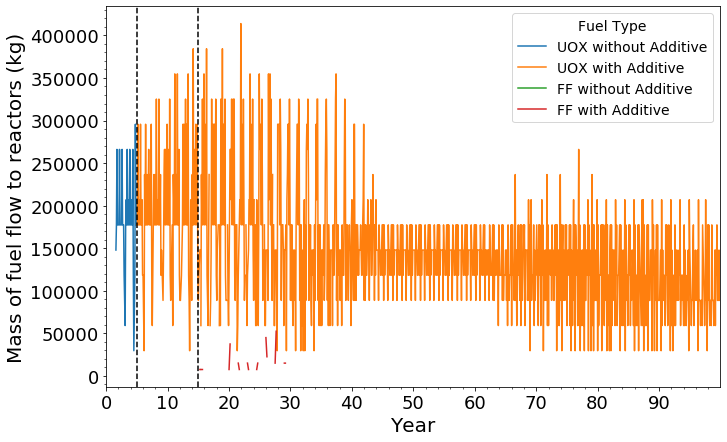

In [145]:
plot_fuel(ev, 'flow')

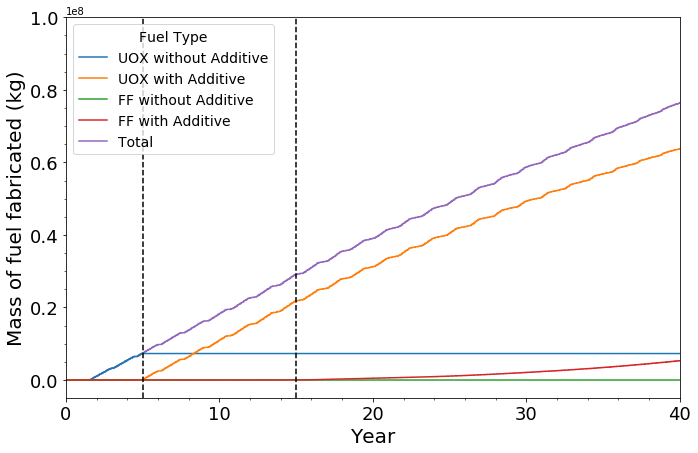

In [191]:
plot_fuel(ev, 'cumul')

# Time Series Power (check constant)

In [192]:
#db = cym.dbopen('../output/test_py.sqlite')
#ev = cym.Evaluator(db=db, write=False)

df_tspower = ev.eval('TimeSeriesPower')
df_tspower['Year'] = df_tspower['Time'] / 12.
# power in GWe
power = df_tspower.groupby(['Year'])['Value'].sum() / 1000.0

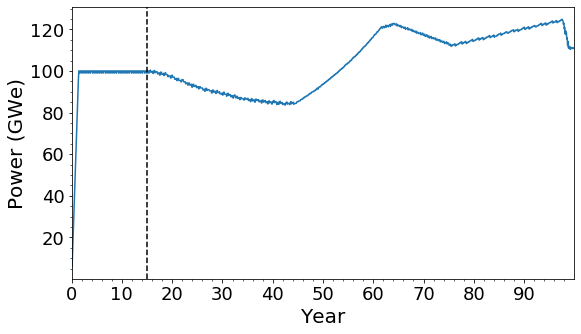

In [193]:
ax = power.plot(x='Year', figsize=(9,5), legend=False)
plt.xlabel(r'Year', fontsize=20)
plt.ylabel(r'Power (GWe)',fontsize=20)
ax.minorticks_on()
#ax.set_ylim(90, 101)
ax.minorticks_on()
ax.set_xticks(np.arange(0, 100, 10))
ax.tick_params(labelsize=18)
plt.axvline(x=trans_sfr/12., color='k', linestyle='--')
plt.show()

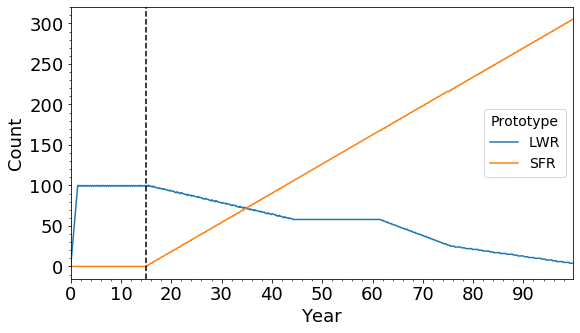

In [194]:
plot_rxtr_enter_exit_total(ev)